In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
%pylab
%matplotlib inline
import os
import math
import time
import tensorflow as tf
from datasets import dataset_utils,cifar10
from tensorflow.contrib import slim

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
dropout_keep_prob=0.8
image_size = 32
step=20000
learning_rate=0.0002
train_dir = '/tmp/cifar10/swish7-lrn'

In [3]:
cifar10_data_dir='/media/ramdisk/data/cifar10'

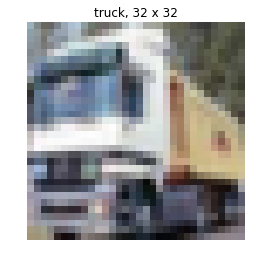

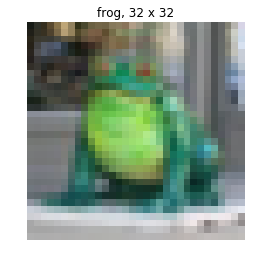

In [4]:
display_step=2

with tf.Graph().as_default(): 
    dataset = cifar10.get_split('train', cifar10_data_dir)
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32, common_queue_min=1)
    image, label = data_provider.get(['image', 'label'])

    with tf.Session() as sess:    
        with slim.queues.QueueRunners(sess):
            for i in range(display_step):
                np_image, np_label = sess.run([image, label])
                height, width, _ = np_image.shape
                class_name = name = dataset.labels_to_names[np_label]
                
                plt.figure()
                plt.imshow(np_image)
                plt.title('%s, %d x %d' % (name, height, width))
                plt.axis('off')
                plt.show()


In [5]:
from tensorflow.python.framework import ops
from tensorflow.python.ops import math_ops

def swish(features):
  # pylint: disable=g-doc-args
  """Computes the Swish activation function: `x * sigmoid(x)`.
  Source: "Searching for Activation Functions" (Ramachandran et al. 2017)
  https://arxiv.org/abs/1710.05941
  Args:
    features: A `Tensor` representing preactivation values.
    name: A name for the operation (optional).
  Returns:
    The activation value.
  """
  # pylint: enable=g-doc-args
  features = ops.convert_to_tensor(features, name="features")
  return features * math_ops.sigmoid(features)

def cnn_swish(images, num_classes, is_training):
    #https://github.com/agrawalnishant/tensorflow-1/tree/master/tensorflow/contrib/slim 
    ##vgg와  cifarndet을 참조함
    with slim.arg_scope([slim.max_pool2d], stride=2): 

        net = slim.repeat(images, 2, slim.conv2d, 64, [3, 3], scope='conv1',activation_fn=swish,normalizer_fn=tf.nn.lrn)
        net = slim.max_pool2d(net, [2, 2], scope='pool1')
        net = slim.repeat(net, 2, slim.conv2d, 128, [3, 3], scope='conv2',activation_fn=swish,normalizer_fn=tf.nn.lrn)
        net = slim.max_pool2d(net, [2, 2], scope='pool2')
        net = slim.repeat(net, 4, slim.conv2d, 256, [3, 3], scope='conv3',activation_fn=swish,normalizer_fn=tf.nn.lrn)
        net = slim.max_pool2d(net, [2, 2], scope='pool3')
        net = slim.repeat(net, 4, slim.conv2d, 512, [3, 3], scope='conv4',activation_fn=swish,normalizer_fn=tf.nn.lrn)
        net = slim.max_pool2d(net, [2, 2], scope='pool4')
       
        net = slim.conv2d(net, 512, [2, 2], padding="VALID", scope='fc6')
        net = slim.dropout(net, dropout_keep_prob, is_training=is_training,
                         scope='dropout6')
        net = slim.conv2d(net, 512, [1, 1], scope='fc8', activation_fn=None)
        net = slim.dropout(net, dropout_keep_prob, is_training=is_training,
                           scope='dropout7')
        net = slim.conv2d(net, num_classes, [1, 1],
                          activation_fn=None,
                          normalizer_fn=None,
                          scope='fc9')
        
        net = tf.squeeze(net, [1,2],name='fc9/squeezed')
        
        return net

In [6]:
from preprocessing import cifarnet_preprocessing

def load_batch(dataset, batch_size=128, height=image_size, width=image_size, is_training=False):
    """Loads a single batch of data.
    
    Args:
      dataset: The dataset to load.
      batch_size: The number of images in the batch.
      height: The size of each image after preprocessing.
      width: The size of each image after preprocessing.
      is_training: Whether or not we're currently training or evaluating.
    
    Returns:
      images: A Tensor of size [batch_size, height, width, 3], image samples that have been preprocessed.
      images_raw: A Tensor of size [batch_size, height, width, 3], image samples that can be used for visualization.
      labels: A Tensor of size [batch_size], whose values range between 0 and dataset.num_classes.
    """
    
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=128,
        common_queue_min=32)
    image_raw, label = data_provider.get(['image', 'label'])
    
    # Preprocess image for usage by Inception.
    image = cifarnet_preprocessing.preprocess_image(image_raw, height, width, is_training=is_training)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    # Batch it up.
    images, images_raw, labels = tf.train.batch(
          [image, image_raw, label],
          batch_size=batch_size,
          num_threads=4,
          capacity=4 * batch_size)
    
    return images, images_raw, labels

In [7]:
%%time
# This might take a few minutes.

print('Will save model to %s' % train_dir)

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)

    dataset = cifar10.get_split('train', cifar10_data_dir)
    images, _, labels = load_batch(dataset)
  

    logits =cnn_swish(images, num_classes=dataset.num_classes, is_training=True)
 

    one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)
    slim.losses.softmax_cross_entropy(logits, one_hot_labels)
    total_loss = slim.losses.get_total_loss()
    

    tf.summary.scalar('losses/Total Loss', total_loss)
    

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = slim.learning.create_train_op(total_loss, optimizer)


    final_loss = slim.learning.train(
      train_op,
      logdir=train_dir,
      number_of_steps=step, 
          log_every_n_steps=10,
        save_interval_secs=100,
      save_summaries_secs=100)
  
    print('Finished training. Final batch loss %d' % final_loss)

Will save model to /tmp/cifar10/swish7-lrn
Instructions for updating:
Use tf.losses.softmax_cross_entropy instead. Note that the order of the logits and labels arguments has been changed.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
INFO:tensorflow:Summary name losses/Total Loss is illegal; using losses/Total_Loss instead.
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
INFO:tensorflow:Starting Session.
INFO:tensorflow:Saving checkpoint to path /tmp/cifar10/swish7-lrn/model.ckpt
INFO:ten

INFO:tensorflow:global step 810: loss = 1.1638 (0.222 sec/step)
INFO:tensorflow:global step 820: loss = 1.4204 (0.200 sec/step)
INFO:tensorflow:global step 830: loss = 1.1971 (0.193 sec/step)
INFO:tensorflow:global step 840: loss = 1.1374 (0.200 sec/step)
INFO:tensorflow:global step 850: loss = 1.1102 (0.200 sec/step)
INFO:tensorflow:global step 860: loss = 1.2624 (0.212 sec/step)
INFO:tensorflow:global step 870: loss = 1.0612 (0.198 sec/step)
INFO:tensorflow:global step 880: loss = 1.1257 (0.209 sec/step)
INFO:tensorflow:global step 890: loss = 1.1024 (0.204 sec/step)
INFO:tensorflow:global step 900: loss = 1.1748 (0.185 sec/step)
INFO:tensorflow:global step 910: loss = 1.2549 (0.207 sec/step)
INFO:tensorflow:global step 920: loss = 1.1955 (0.190 sec/step)
INFO:tensorflow:global step 930: loss = 1.1235 (0.204 sec/step)
INFO:tensorflow:global step 940: loss = 1.1373 (0.205 sec/step)
INFO:tensorflow:global step 950: loss = 1.0729 (0.203 sec/step)
INFO:tensorflow:global step 960: loss = 

INFO:tensorflow:global step 2000: loss = 0.7028 (0.196 sec/step)
INFO:tensorflow:global step 2010: loss = 0.7828 (0.210 sec/step)
INFO:tensorflow:global step 2020: loss = 0.9002 (0.207 sec/step)
INFO:tensorflow:global step 2030: loss = 0.8979 (0.211 sec/step)
INFO:tensorflow:global step 2040: loss = 0.7373 (0.207 sec/step)
INFO:tensorflow:global step 2050: loss = 0.8911 (0.204 sec/step)
INFO:tensorflow:global step 2060: loss = 0.7818 (0.204 sec/step)
INFO:tensorflow:global step 2070: loss = 0.7720 (0.216 sec/step)
INFO:tensorflow:global step 2080: loss = 0.7292 (0.206 sec/step)
INFO:tensorflow:global step 2090: loss = 0.9663 (0.191 sec/step)
INFO:tensorflow:global step 2100: loss = 0.7670 (0.213 sec/step)
INFO:tensorflow:global step 2110: loss = 0.8015 (0.203 sec/step)
INFO:tensorflow:global step 2120: loss = 0.8914 (0.196 sec/step)
INFO:tensorflow:global step 2130: loss = 0.7310 (0.190 sec/step)
INFO:tensorflow:global step 2140: loss = 0.6670 (0.213 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 3220: loss = 0.6020 (0.195 sec/step)
INFO:tensorflow:global step 3230: loss = 0.6692 (0.197 sec/step)
INFO:tensorflow:global step 3240: loss = 0.5142 (0.194 sec/step)
INFO:tensorflow:global step 3250: loss = 0.4879 (0.200 sec/step)
INFO:tensorflow:global step 3260: loss = 0.6900 (0.193 sec/step)
INFO:tensorflow:global step 3270: loss = 0.4843 (0.207 sec/step)
INFO:tensorflow:global step 3280: loss = 0.5459 (0.192 sec/step)
INFO:tensorflow:global step 3290: loss = 0.6287 (0.216 sec/step)
INFO:tensorflow:global step 3300: loss = 0.4752 (0.194 sec/step)
INFO:tensorflow:global step 3310: loss = 0.6228 (0.198 sec/step)
INFO:tensorflow:global step 3320: loss = 0.6567 (0.199 sec/step)
INFO:tensorflow:global step 3330: loss = 0.7590 (0.188 sec/step)
INFO:tensorflow:global step 3340: loss = 0.6854 (0.187 sec/step)
INFO:tensorflow:global step 3350: loss = 0.5210 (0.192 sec/step)
INFO:tensorflow:global step 3360: loss = 0.6262 (0.185 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 4430: loss = 0.6042 (0.207 sec/step)
INFO:tensorflow:global step 4440: loss = 0.5482 (0.198 sec/step)
INFO:tensorflow:global step 4450: loss = 0.3041 (0.197 sec/step)
INFO:tensorflow:global step 4460: loss = 0.4401 (0.201 sec/step)
INFO:tensorflow:global step 4470: loss = 0.3596 (0.209 sec/step)
INFO:tensorflow:Saving checkpoint to path /tmp/cifar10/swish7-lrn/model.ckpt
INFO:tensorflow:global_step/sec: 4.98999
INFO:tensorflow:Recording summary at step 4478.
INFO:tensorflow:global step 4480: loss = 0.5171 (0.205 sec/step)
INFO:tensorflow:global step 4490: loss = 0.3627 (0.204 sec/step)
INFO:tensorflow:global step 4500: loss = 0.3922 (0.197 sec/step)
INFO:tensorflow:global step 4510: loss = 0.4162 (0.207 sec/step)
INFO:tensorflow:global step 4520: loss = 0.4743 (0.205 sec/step)
INFO:tensorflow:global step 4530: loss = 0.5709 (0.194 sec/step)
INFO:tensorflow:global step 4540: loss = 0.4661 (0.199 sec/step)
INFO:tensorflow:global step 4550: loss = 0.4398 (0.190

INFO:tensorflow:global step 5630: loss = 0.3585 (0.188 sec/step)
INFO:tensorflow:global step 5640: loss = 0.2455 (0.200 sec/step)
INFO:tensorflow:global step 5650: loss = 0.3387 (0.186 sec/step)
INFO:tensorflow:global step 5660: loss = 0.2376 (0.185 sec/step)
INFO:tensorflow:global step 5670: loss = 0.3440 (0.197 sec/step)
INFO:tensorflow:global step 5680: loss = 0.2791 (0.208 sec/step)
INFO:tensorflow:global step 5690: loss = 0.2347 (0.202 sec/step)
INFO:tensorflow:global step 5700: loss = 0.2612 (0.200 sec/step)
INFO:tensorflow:global step 5710: loss = 0.3786 (0.193 sec/step)
INFO:tensorflow:global step 5720: loss = 0.3186 (0.190 sec/step)
INFO:tensorflow:global step 5730: loss = 0.3386 (0.208 sec/step)
INFO:tensorflow:global step 5740: loss = 0.2254 (0.206 sec/step)
INFO:tensorflow:global step 5750: loss = 0.2523 (0.187 sec/step)
INFO:tensorflow:global step 5760: loss = 0.2539 (0.201 sec/step)
INFO:tensorflow:global step 5770: loss = 0.2339 (0.212 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 6860: loss = 0.1418 (0.203 sec/step)
INFO:tensorflow:global step 6870: loss = 0.2823 (0.198 sec/step)
INFO:tensorflow:global step 6880: loss = 0.1824 (0.199 sec/step)
INFO:tensorflow:global step 6890: loss = 0.1778 (0.201 sec/step)
INFO:tensorflow:global step 6900: loss = 0.2686 (0.197 sec/step)
INFO:tensorflow:global step 6910: loss = 0.2158 (0.198 sec/step)
INFO:tensorflow:global step 6920: loss = 0.3246 (0.192 sec/step)
INFO:tensorflow:global step 6930: loss = 0.3227 (0.201 sec/step)
INFO:tensorflow:global step 6940: loss = 0.1831 (0.198 sec/step)
INFO:tensorflow:global step 6950: loss = 0.2620 (0.210 sec/step)
INFO:tensorflow:global step 6960: loss = 0.2232 (0.191 sec/step)
INFO:tensorflow:Saving checkpoint to path /tmp/cifar10/swish7-lrn/model.ckpt
INFO:tensorflow:Recording summary at step 6966.
INFO:tensorflow:global step 6970: loss = 0.2854 (0.186 sec/step)
INFO:tensorflow:global step 6980: loss = 0.2102 (0.194 sec/step)
INFO:tensorflow:global step 69

INFO:tensorflow:global step 8070: loss = 0.2332 (0.227 sec/step)
INFO:tensorflow:global step 8080: loss = 0.2940 (0.188 sec/step)
INFO:tensorflow:global step 8090: loss = 0.2223 (0.193 sec/step)
INFO:tensorflow:global step 8100: loss = 0.2434 (0.213 sec/step)
INFO:tensorflow:global step 8110: loss = 0.1736 (0.208 sec/step)
INFO:tensorflow:global step 8120: loss = 0.1334 (0.201 sec/step)
INFO:tensorflow:global step 8130: loss = 0.1636 (0.197 sec/step)
INFO:tensorflow:global step 8140: loss = 0.1397 (0.201 sec/step)
INFO:tensorflow:global step 8150: loss = 0.0995 (0.190 sec/step)
INFO:tensorflow:global step 8160: loss = 0.2729 (0.208 sec/step)
INFO:tensorflow:global step 8170: loss = 0.1009 (0.200 sec/step)
INFO:tensorflow:global step 8180: loss = 0.2562 (0.196 sec/step)
INFO:tensorflow:global step 8190: loss = 0.1950 (0.186 sec/step)
INFO:tensorflow:global step 8200: loss = 0.2313 (0.195 sec/step)
INFO:tensorflow:global step 8210: loss = 0.2046 (0.196 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 9300: loss = 0.0813 (0.195 sec/step)
INFO:tensorflow:global step 9310: loss = 0.0943 (0.194 sec/step)
INFO:tensorflow:global step 9320: loss = 0.0738 (0.197 sec/step)
INFO:tensorflow:global step 9330: loss = 0.1268 (0.190 sec/step)
INFO:tensorflow:global step 9340: loss = 0.0685 (0.198 sec/step)
INFO:tensorflow:global step 9350: loss = 0.2173 (0.210 sec/step)
INFO:tensorflow:global step 9360: loss = 0.1366 (0.201 sec/step)
INFO:tensorflow:global step 9370: loss = 0.0847 (0.197 sec/step)
INFO:tensorflow:global step 9380: loss = 0.1056 (0.206 sec/step)
INFO:tensorflow:global step 9390: loss = 0.0965 (0.191 sec/step)
INFO:tensorflow:global step 9400: loss = 0.0532 (0.212 sec/step)
INFO:tensorflow:global step 9410: loss = 0.0932 (0.194 sec/step)
INFO:tensorflow:global step 9420: loss = 0.0571 (0.211 sec/step)
INFO:tensorflow:global step 9430: loss = 0.1059 (0.194 sec/step)
INFO:tensorflow:global step 9440: loss = 0.1068 (0.187 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 10500: loss = 0.1195 (0.207 sec/step)
INFO:tensorflow:global step 10510: loss = 0.0970 (0.194 sec/step)
INFO:tensorflow:global step 10520: loss = 0.1847 (0.202 sec/step)
INFO:tensorflow:global step 10530: loss = 0.1175 (0.196 sec/step)
INFO:tensorflow:global step 10540: loss = 0.1587 (0.197 sec/step)
INFO:tensorflow:global step 10550: loss = 0.0835 (0.193 sec/step)
INFO:tensorflow:global step 10560: loss = 0.1089 (0.218 sec/step)
INFO:tensorflow:global step 10570: loss = 0.0467 (0.205 sec/step)
INFO:tensorflow:global step 10580: loss = 0.0642 (0.223 sec/step)
INFO:tensorflow:global step 10590: loss = 0.1426 (0.219 sec/step)
INFO:tensorflow:global step 10600: loss = 0.0499 (0.208 sec/step)
INFO:tensorflow:global step 10610: loss = 0.1341 (0.210 sec/step)
INFO:tensorflow:global step 10620: loss = 0.0920 (0.202 sec/step)
INFO:tensorflow:global step 10630: loss = 0.0721 (0.208 sec/step)
INFO:tensorflow:global step 10640: loss = 0.1425 (0.224 sec/step)
INFO:tenso

INFO:tensorflow:global step 11710: loss = 0.0602 (0.201 sec/step)
INFO:tensorflow:global step 11720: loss = 0.0323 (0.184 sec/step)
INFO:tensorflow:global step 11730: loss = 0.0724 (0.195 sec/step)
INFO:tensorflow:global step 11740: loss = 0.0169 (0.184 sec/step)
INFO:tensorflow:global step 11750: loss = 0.0185 (0.210 sec/step)
INFO:tensorflow:global step 11760: loss = 0.0380 (0.226 sec/step)
INFO:tensorflow:global step 11770: loss = 0.0507 (0.212 sec/step)
INFO:tensorflow:global step 11780: loss = 0.0308 (0.190 sec/step)
INFO:tensorflow:global step 11790: loss = 0.0387 (0.198 sec/step)
INFO:tensorflow:global step 11800: loss = 0.0879 (0.193 sec/step)
INFO:tensorflow:global step 11810: loss = 0.0686 (0.193 sec/step)
INFO:tensorflow:global step 11820: loss = 0.0499 (0.203 sec/step)
INFO:tensorflow:global step 11830: loss = 0.1087 (0.191 sec/step)
INFO:tensorflow:global step 11840: loss = 0.0761 (0.189 sec/step)
INFO:tensorflow:global step 11850: loss = 0.0550 (0.202 sec/step)
INFO:tenso

INFO:tensorflow:global step 12920: loss = 0.0565 (0.195 sec/step)
INFO:tensorflow:global step 12930: loss = 0.0347 (0.203 sec/step)
INFO:tensorflow:global step 12940: loss = 0.0160 (0.201 sec/step)
INFO:tensorflow:Saving checkpoint to path /tmp/cifar10/swish7-lrn/model.ckpt
INFO:tensorflow:Recording summary at step 12943.
INFO:tensorflow:global step 12950: loss = 0.0972 (0.190 sec/step)
INFO:tensorflow:global step 12960: loss = 0.0417 (0.196 sec/step)
INFO:tensorflow:global step 12970: loss = 0.0868 (0.188 sec/step)
INFO:tensorflow:global step 12980: loss = 0.0418 (0.220 sec/step)
INFO:tensorflow:global step 12990: loss = 0.0324 (0.196 sec/step)
INFO:tensorflow:global step 13000: loss = 0.0182 (0.201 sec/step)
INFO:tensorflow:global step 13010: loss = 0.1043 (0.206 sec/step)
INFO:tensorflow:global step 13020: loss = 0.0842 (0.210 sec/step)
INFO:tensorflow:global step 13030: loss = 0.0845 (0.200 sec/step)
INFO:tensorflow:global step 13040: loss = 0.1048 (0.231 sec/step)
INFO:tensorflow:

INFO:tensorflow:global step 14110: loss = 0.0305 (0.198 sec/step)
INFO:tensorflow:global step 14120: loss = 0.0365 (0.198 sec/step)
INFO:tensorflow:global step 14130: loss = 0.0889 (0.193 sec/step)
INFO:tensorflow:global step 14140: loss = 0.1036 (0.193 sec/step)
INFO:tensorflow:global step 14150: loss = 0.0359 (0.189 sec/step)
INFO:tensorflow:global step 14160: loss = 0.0613 (0.197 sec/step)
INFO:tensorflow:global step 14170: loss = 0.0139 (0.203 sec/step)
INFO:tensorflow:global step 14180: loss = 0.0953 (0.206 sec/step)
INFO:tensorflow:global step 14190: loss = 0.0225 (0.219 sec/step)
INFO:tensorflow:global step 14200: loss = 0.0025 (0.195 sec/step)
INFO:tensorflow:global step 14210: loss = 0.0731 (0.189 sec/step)
INFO:tensorflow:global step 14220: loss = 0.0333 (0.193 sec/step)
INFO:tensorflow:global step 14230: loss = 0.0411 (0.200 sec/step)
INFO:tensorflow:global step 14240: loss = 0.0465 (0.199 sec/step)
INFO:tensorflow:global step 14250: loss = 0.0484 (0.208 sec/step)
INFO:tenso

INFO:tensorflow:global step 15320: loss = 0.0609 (0.187 sec/step)
INFO:tensorflow:global step 15330: loss = 0.0336 (0.203 sec/step)
INFO:tensorflow:global step 15340: loss = 0.0048 (0.199 sec/step)
INFO:tensorflow:global step 15350: loss = 0.0526 (0.214 sec/step)
INFO:tensorflow:global step 15360: loss = 0.1169 (0.190 sec/step)
INFO:tensorflow:global step 15370: loss = 0.0792 (0.202 sec/step)
INFO:tensorflow:global step 15380: loss = 0.1135 (0.192 sec/step)
INFO:tensorflow:global step 15390: loss = 0.0600 (0.194 sec/step)
INFO:tensorflow:global step 15400: loss = 0.0687 (0.195 sec/step)
INFO:tensorflow:global step 15410: loss = 0.1131 (0.203 sec/step)
INFO:tensorflow:global step 15420: loss = 0.0432 (0.197 sec/step)
INFO:tensorflow:global step 15430: loss = 0.0427 (0.198 sec/step)
INFO:tensorflow:Saving checkpoint to path /tmp/cifar10/swish7-lrn/model.ckpt
INFO:tensorflow:global step 15440: loss = 0.0491 (0.196 sec/step)
INFO:tensorflow:Recording summary at step 15440.
INFO:tensorflow:

INFO:tensorflow:global step 16510: loss = 0.0384 (0.201 sec/step)
INFO:tensorflow:global step 16520: loss = 0.0181 (0.203 sec/step)
INFO:tensorflow:global step 16530: loss = 0.0324 (0.206 sec/step)
INFO:tensorflow:global step 16540: loss = 0.0350 (0.221 sec/step)
INFO:tensorflow:global step 16550: loss = 0.0759 (0.191 sec/step)
INFO:tensorflow:global step 16560: loss = 0.0221 (0.205 sec/step)
INFO:tensorflow:global step 16570: loss = 0.0687 (0.202 sec/step)
INFO:tensorflow:global step 16580: loss = 0.0487 (0.187 sec/step)
INFO:tensorflow:global step 16590: loss = 0.0479 (0.204 sec/step)
INFO:tensorflow:global step 16600: loss = 0.0046 (0.186 sec/step)
INFO:tensorflow:global step 16610: loss = 0.0288 (0.196 sec/step)
INFO:tensorflow:global step 16620: loss = 0.0376 (0.209 sec/step)
INFO:tensorflow:global step 16630: loss = 0.0985 (0.193 sec/step)
INFO:tensorflow:global step 16640: loss = 0.0075 (0.208 sec/step)
INFO:tensorflow:global step 16650: loss = 0.1273 (0.190 sec/step)
INFO:tenso

INFO:tensorflow:global step 17720: loss = 0.0176 (0.203 sec/step)
INFO:tensorflow:global step 17730: loss = 0.0457 (0.236 sec/step)
INFO:tensorflow:global step 17740: loss = 0.0081 (0.191 sec/step)
INFO:tensorflow:global step 17750: loss = 0.0327 (0.204 sec/step)
INFO:tensorflow:global step 17760: loss = 0.0655 (0.196 sec/step)
INFO:tensorflow:global step 17770: loss = 0.0407 (0.223 sec/step)
INFO:tensorflow:global step 17780: loss = 0.0229 (0.206 sec/step)
INFO:tensorflow:global step 17790: loss = 0.0549 (0.186 sec/step)
INFO:tensorflow:global step 17800: loss = 0.0446 (0.187 sec/step)
INFO:tensorflow:global step 17810: loss = 0.0336 (0.201 sec/step)
INFO:tensorflow:global step 17820: loss = 0.0567 (0.193 sec/step)
INFO:tensorflow:global step 17830: loss = 0.0100 (0.202 sec/step)
INFO:tensorflow:global step 17840: loss = 0.0146 (0.187 sec/step)
INFO:tensorflow:global step 17850: loss = 0.0613 (0.206 sec/step)
INFO:tensorflow:global step 17860: loss = 0.0092 (0.201 sec/step)
INFO:tenso

INFO:tensorflow:Saving checkpoint to path /tmp/cifar10/swish7-lrn/model.ckpt
INFO:tensorflow:Recording summary at step 18926.
INFO:tensorflow:global step 18930: loss = 0.0123 (0.186 sec/step)
INFO:tensorflow:global step 18940: loss = 0.0213 (0.191 sec/step)
INFO:tensorflow:global step 18950: loss = 0.0385 (0.202 sec/step)
INFO:tensorflow:global step 18960: loss = 0.0300 (0.187 sec/step)
INFO:tensorflow:global step 18970: loss = 0.0298 (0.219 sec/step)
INFO:tensorflow:global step 18980: loss = 0.0350 (0.190 sec/step)
INFO:tensorflow:global step 18990: loss = 0.0384 (0.184 sec/step)
INFO:tensorflow:global step 19000: loss = 0.0671 (0.195 sec/step)
INFO:tensorflow:global step 19010: loss = 0.0356 (0.218 sec/step)
INFO:tensorflow:global step 19020: loss = 0.0606 (0.216 sec/step)
INFO:tensorflow:global step 19030: loss = 0.0710 (0.214 sec/step)
INFO:tensorflow:global step 19040: loss = 0.0131 (0.193 sec/step)
INFO:tensorflow:global step 19050: loss = 0.0281 (0.195 sec/step)
INFO:tensorflow:

In [8]:
%%time


with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.DEBUG)
    
    dataset = cifar10.get_split('test', cifar10_data_dir)
    images, _, labels = load_batch(dataset)
    
    logits = cnn_swish(images, num_classes=dataset.num_classes, is_training=False)
    predictions = tf.argmax(logits, 1)
    

    names_to_values, names_to_updates = slim.metrics.aggregate_metric_map({
        'eval/mse':slim.metrics.streaming_mean_squared_error(predictions, labels),
        'eval/Accuracy': slim.metrics.streaming_accuracy(predictions, labels),
        'eval/TruePositives': slim.metrics.streaming_true_positives(predictions, labels),        
        'eval/TrueNegatives': slim.metrics.streaming_true_negatives(predictions, labels),
        'eval/FalsePositives': slim.metrics.streaming_false_positives(predictions, labels),
        'eval/FalseNegatives': slim.metrics.streaming_false_negatives(predictions, labels),
        'eval/Recall5': slim.metrics.streaming_sparse_recall_at_k(logits, labels, 5),
    })

    print('Running evaluation Loop...')
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    metric_values = slim.evaluation.evaluate_once(
        master='',
        checkpoint_path=checkpoint_path,
        logdir=train_dir,
        eval_op=list(names_to_updates.values()),
        final_op=list(names_to_values.values())
    )

    names_to_values = dict(zip(names_to_values.keys(), metric_values))
    for name in names_to_values:
        print('%s: %f' % (name, names_to_values[name]))


Instructions for updating:
Please switch to tf.metrics.accuracy. Note that the order of the inputs of labels and predictions have been switched.
Running evaluation Loop...
INFO:tensorflow:Starting evaluation at 2017-12-03-19:57:48
INFO:tensorflow:Restoring parameters from /tmp/cifar10/swish7-lrn/model.ckpt-20000
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-12-03-19:57:49
eval/Accuracy: 0.812500
eval/mse: 3.078125
eval/FalsePositives: 1.000000
eval/TruePositives: 117.000000
eval/Recall5: 0.992188
eval/FalseNegatives: 1.000000
eval/TrueNegatives: 9.000000
CPU times: user 1.54 s, sys: 304 ms, total: 1.84 s
Wall time: 1.1 s


INFO:tensorflow:Restoring parameters from /tmp/cifar10/swish7-lrn/model.ckpt-20000


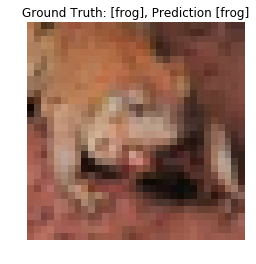

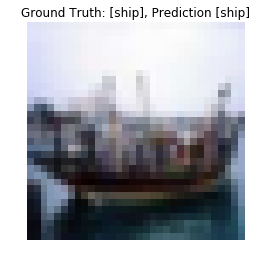

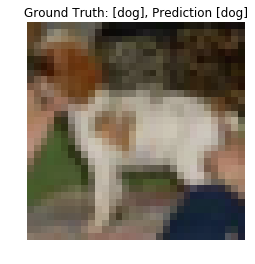

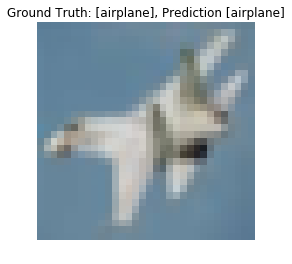

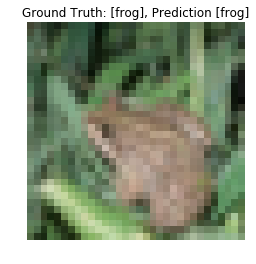

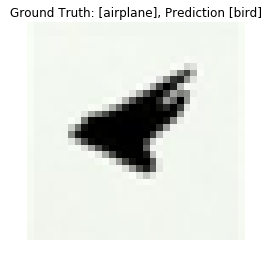

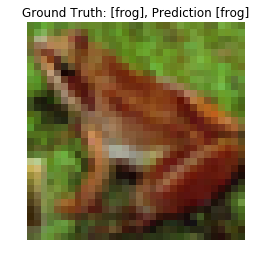

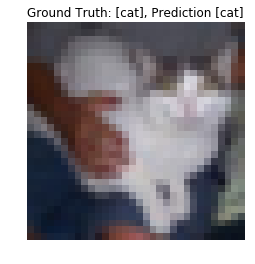

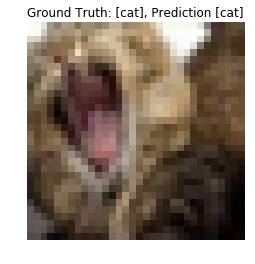

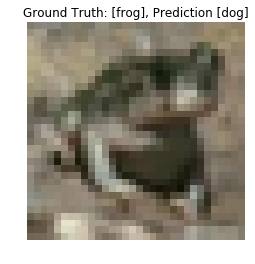

CPU times: user 3.7 s, sys: 1.9 s, total: 5.6 s
Wall time: 1.86 s


In [9]:
%%time
batch_size = 10
with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = cifar10.get_split('test',cifar10_data_dir)
    images, images_raw, labels = load_batch(dataset, height=image_size, width=image_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    logits = cnn_swish(images, num_classes=dataset.num_classes, is_training=True)
    probabilities = tf.nn.softmax(logits)
    
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    init_fn = slim.assign_from_checkpoint_fn(
      checkpoint_path,
      slim.get_variables_to_restore())
    
    with tf.Session() as sess:
        with slim.queues.QueueRunners(sess):
            sess.run(tf.local_variables_initializer())
            init_fn(sess)
            np_probabilities, np_images_raw, np_labels = sess.run([probabilities, images_raw, labels])
    
            for i in range(batch_size): 
                image = np_images_raw[i, :, :, :]
                true_label = np_labels[i]
                predicted_label = np.argmax(np_probabilities[i, :])
                predicted_name = dataset.labels_to_names[predicted_label]
                true_name = dataset.labels_to_names[true_label]
                
                plt.figure()
                plt.imshow(image.astype(np.uint8))
                plt.title('Ground Truth: [%s], Prediction [%s]' % (true_name, predicted_name))
                plt.axis('off')
                plt.show()